In [3]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal, ttest_ind
from scipy.stats import spearmanr
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('data.xlsx', sheet_name='data')
df.head()

,appointmentId,inspectionStartTime,year,month,engineTransmission_battery_value,engineTransmission_battery_cc_value_0,engineTransmission_battery_cc_value_1,engineTransmission_battery_cc_value_2,engineTransmission_battery_cc_value_3,engineTransmission_battery_cc_value_4,...,engineTransmission_gearShifting_cc_value_1,engineTransmission_gearShifting_cc_value_2,engineTransmission_comments_value_0,engineTransmission_comments_value_1,engineTransmission_comments_value_2,engineTransmission_comments_value_3,engineTransmission_comments_value_4,fuel_type,odometer_reading,rating_engineTransmission
0,aj_01,2019-02-03 15:43:48,2008,8,No,Weak,NaN,NaN,NaN,NaN,...,NaN,NaN,Pickup Low,Starter Motor / Solenoid malfunctioning,NaN,NaN,NaN,Petrol + CNG,124600,3.0
1,aj_02,2019-01-16 13:02:12,2007,5,Yes,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol + CNG,78108,4.0
2,aj_03,2019-02-09 13:31:04,2012,5,Yes,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Diesel,93348,3.5
3,aj_04,2019-01-18 11:02:53,2013,1,Yes,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol + CNG,48233,3.5
4,aj_05,2019-01-27 12:12:06,2011,7,Yes,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol + CNG,74368,4.0


## Objective
1. Predict the engine rating based on the inspection parameters using only the provided dataset
2. find all the cases/outliers where the rating has been given incorrectly as compared to current condition of the engine
3. find trends, outliers, relative importance of variables with deviation in target variable
4. generate insights summary

Your solution should at a minimum do the following:
*  Load the data into memory· Prepare the data for modelling
*  EDA of the variables
*  Build a model on training data
*  Test the model on testing data
*  Provide some measure of performance
*  Outlier analysis and detection
tection

## Data Understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26307 entries, 0 to 26306
Data columns (total 73 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   appointmentId                                              26307 non-null  object        
 1   inspectionStartTime                                        26307 non-null  datetime64[ns]
 2   year                                                       26307 non-null  int64         
 3   month                                                      26307 non-null  int64         
 4   engineTransmission_battery_value                           26307 non-null  object        
 5   engineTransmission_battery_cc_value_0                      3438 non-null   object        
 6   engineTransmission_battery_cc_value_1                      430 non-null    object        
 7   engineTransmission_battery_cc_v

In [6]:
# From the info, it seems a lot of columns have high null ratio. Check null rate in all columns
null_percent = df.isnull().sum()*100/len(df)
null_percent[lambda x : x>50].round(4).sort_values(ascending=False)

engineTransmission_engineOil_cc_value_9                 100.0000
engineTransmission_engine_cc_value_10                   100.0000
engineTransmission_clutch_cc_value_6                     99.9962
engineTransmission_engineOil_cc_value_8                  99.9924
engineTransmission_engine_cc_value_9                     99.9886
engineTransmission_engine_cc_value_8                     99.9848
engineTransmission_battery_cc_value_4                    99.9848
engineTransmission_clutch_cc_value_5                     99.9734
engineTransmission_engine_cc_value_7                     99.9696
engineTransmission_coolant_cc_value_3                    99.9696
engineTransmission_engineOil_cc_value_7                  99.9582
engineTransmission_comments_value_4                      99.9468
engineTransmission_battery_cc_value_3                    99.9392
engineTransmission_engine_cc_value_6                     99.8594
engineTransmission_clutch_cc_value_4                     99.8365
engineTransmission_commen

### Null Imputation

In [7]:
print("Count of columns with less than 50% fill rate: ",len(null_percent[lambda x : x>50]))

Count of columns with less than 50% fill rate:  51


There are 72 predictor variables, 23 out of those have less than 1% fill-rate

We have 5 columns containing Inspector comments, we can get rid of them for now

We can't simply drop all the other columns as they contain extra information about the malfunction of the corresponding car part. From the data dictionary, it seems that null values have to be imputed as "yes".

We can drop 'engineTransmission_engine_cc_value_10','engineTransmission_engineOil_cc_value_9' columns as they are completely empty.

In [8]:
df.drop(['engineTransmission_engine_cc_value_10', 'engineTransmission_engineOil_cc_value_9'], axis=1, inplace=True, errors='ignore')

In [9]:
cols = [label for label in df.columns if any(x in label for x in ['comments'])]
df.drop(cols, axis = 1,inplace = True)

In [10]:
# Impute nulls in all of the columns with 'current condition if not yes' as per data dictionary
cols = [label for label in df.columns if any(x in label for x in ['engineTransmission'])]
df[cols] = df[cols].fillna('yes')

In [11]:
print("Number of Categorical columns: ", df.select_dtypes('O').shape[1])
print("Number of Continous columns: ", df.select_dtypes(include=['float64','int64']).shape[1])
print("Number of Timestamp columns: ", df.select_dtypes('datetime64').shape[1])

Number of Categorical columns:  61
Number of Continous columns:  4
Number of Timestamp columns:  1


## Exploratory Data Analysis

In [12]:
if 'appointmentId' in df.columns:
    is_unique = df['appointmentId'].nunique() == df['appointmentId'].count()
    print(f"Is appointmentId unique? {is_unique}")
else:
    print("appointmentId column not found (likely already dropped or set as index).")

Is appointmentId unique? True


In [13]:
# Print all columns to find the right name
print([col for col in df.columns if 'time' in col.lower()])

# Or print all columns
print(df.columns)

['inspectionStartTime']
Index(['appointmentId', 'inspectionStartTime', 'year', 'month',
       'engineTransmission_battery_value',
       'engineTransmission_battery_cc_value_0',
       'engineTransmission_battery_cc_value_1',
       'engineTransmission_battery_cc_value_2',
       'engineTransmission_battery_cc_value_3',
       'engineTransmission_battery_cc_value_4',
       'engineTransmission_engineoilLevelDipstick_value',
       'engineTransmission_engineOilLevelDipstick_cc_value_0',
       'engineTransmission_engineOil',
       'engineTransmission_engineOil_cc_value_0',
       'engineTransmission_engineOil_cc_value_1',
       'engineTransmission_engineOil_cc_value_2',
       'engineTransmission_engineOil_cc_value_3',
       'engineTransmission_engineOil_cc_value_4',
       'engineTransmission_engineOil_cc_value_5',
       'engineTransmission_engineOil_cc_value_6',
       'engineTransmission_engineOil_cc_value_7',
       'engineTransmission_engineOil_cc_value_8',
       'engineTrans

In [14]:
print("We have", (df['inspectionStartTime'].max()-df['inspectionStartTime'].min()).days, "days of data")

We have 103 days of data


In [15]:
# Extract the inspection month, date, day of week & hour
df['inspection_hour'] = df['inspectionStartTime'].dt.hour
df['inspection_mon'] = df['inspectionStartTime'].dt.month
df['inspection_date'] = df['inspectionStartTime'].dt.date
df['inspection_dow'] = df['inspectionStartTime'].dt.day_name()

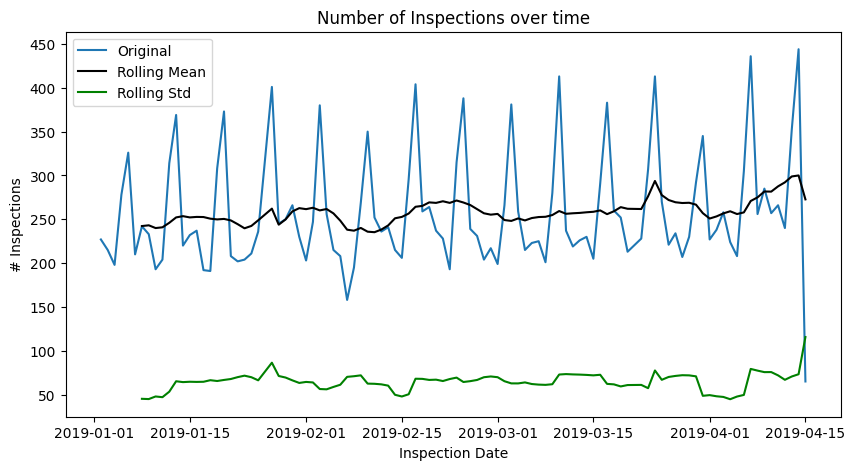

In [16]:
timeSeries = df.groupby(['inspection_date']).count()['appointmentId'].reset_index()
timeSeries = timeSeries.loc[:, ["inspection_date","appointmentId"]]
timeSeries.index = timeSeries.inspection_date
ts = timeSeries.drop("inspection_date",axis=1)

plt.figure(figsize=(10, 5))
plt.plot(df.groupby(['inspection_date'])['appointmentId'].count(), label='Original')
rolmean = ts.rolling(7).mean()
rolstd = ts.rolling(7).std() 
mean = plt.plot(rolmean, color='black', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.xlabel("Inspection Date")
plt.ylabel("# Inspections")
plt.title("Number of Inspections over time")
plt.legend()
plt.show()

Text(0, 0.5, 'Count of Inspections')

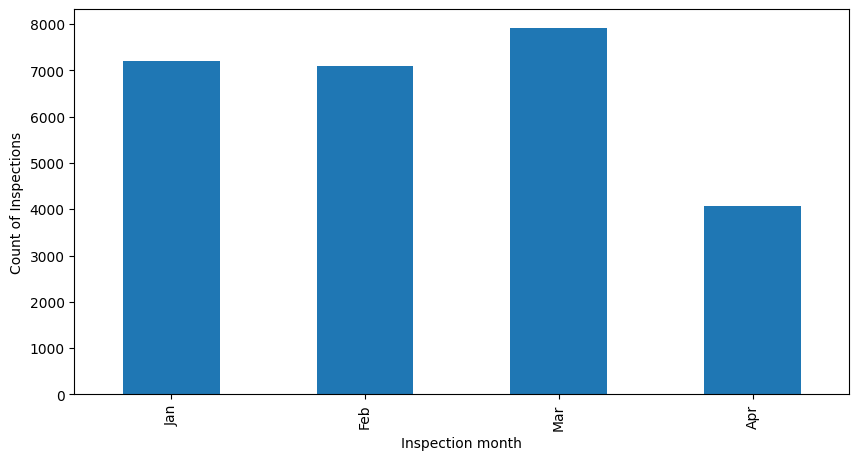

In [17]:
plt.figure(figsize=(10, 5))

df.groupby(['inspection_mon'])['appointmentId'].count().plot.bar()
plt.xticks(np.arange(0,4),['Jan','Feb', 'Mar','Apr'])
plt.xlabel("Inspection month")
plt.ylabel("Count of Inspections")

In [18]:
print("Avg Daily inspections: ", df.groupby(['inspection_date']).count()['appointmentId'].mean())

Avg Daily inspections:  257.9117647058824


Text(0, 0.5, 'Average #Inspections')

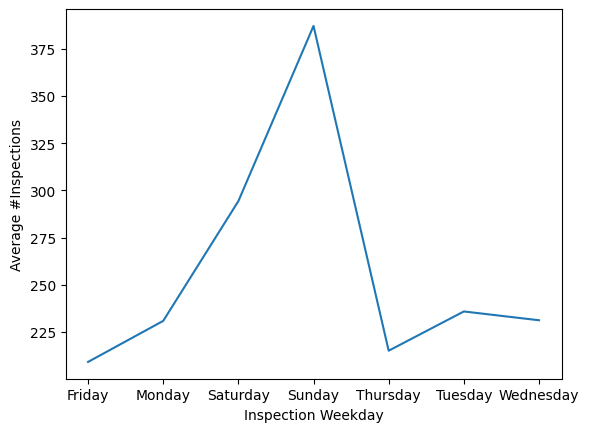

In [19]:
dow_ct= df.groupby(['inspection_date','inspection_dow']).count().reset_index()
plt.plot(dow_ct.groupby(['inspection_dow'])['appointmentId'].mean())
plt.xlabel("Inspection Weekday")
plt.ylabel("Average #Inspections")

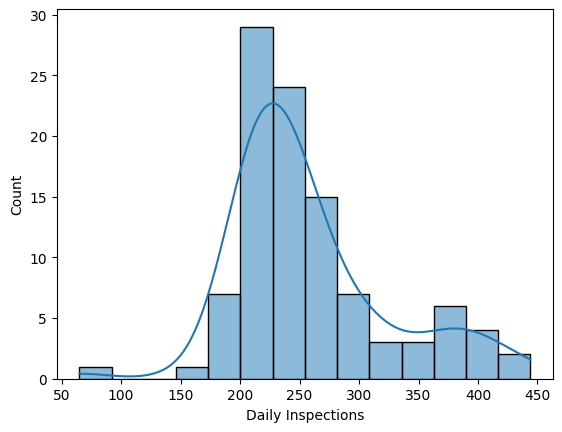

In [20]:
sns.histplot(df.groupby('inspection_date').count()['appointmentId'], kde=True)
plt.xlabel("Daily Inspections")
plt.show()

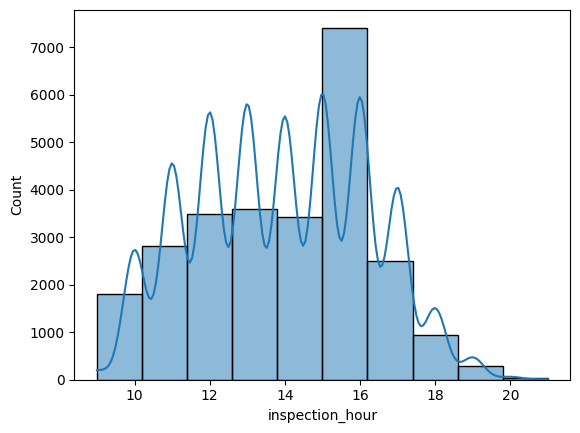

In [21]:
sns.histplot(data=df, x='inspection_hour', kde=True, bins=10)
plt.show()

* As you can see, we have data for 103 days of inspections in 2019
* Average number of inspections ossilates between 150 and 450
* Most inspections happen on Sunday followed by Saturdays, with majority during nid-day between 15:00 to 16:00

In [22]:
# Distribution of target column 'rating_engineTransmission'
df['rating_engineTransmission'].value_counts(normalize=True)

rating_engineTransmission
4.0    0.385905
3.5    0.225947
3.0    0.166458
4.5    0.083970
5.0    0.061695
1.0    0.055346
2.5    0.015965
2.0    0.004447
1.5    0.000228
0.5    0.000038
Name: proportion, dtype: float64

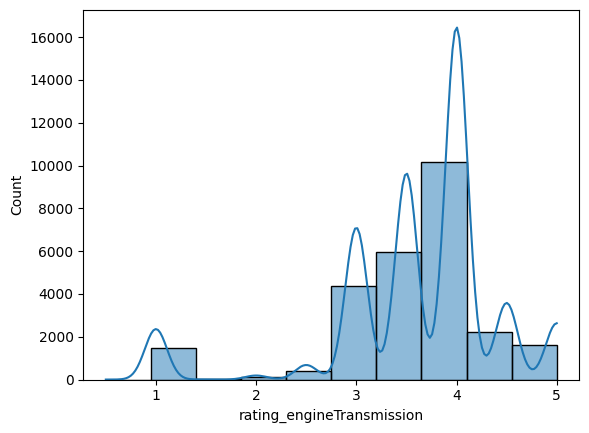

In [23]:
sns.histplot(data=df, x='rating_engineTransmission', bins=10, kde=True)
plt.show()

Text(0, 0.5, 'Count of Inspections')

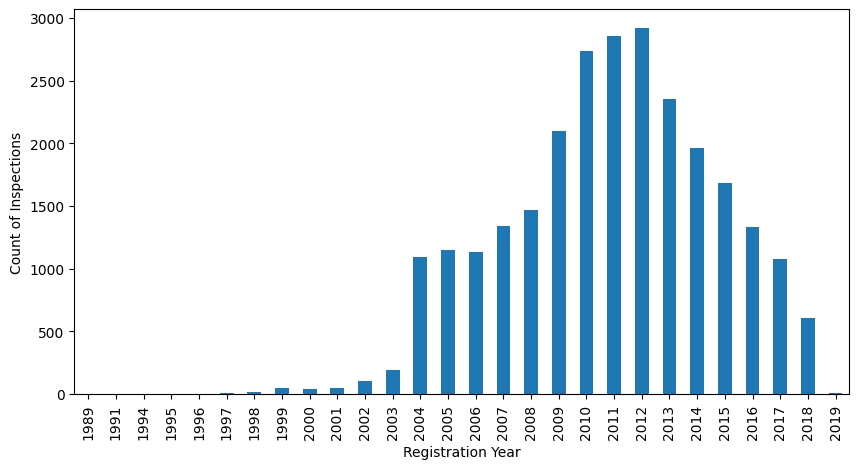

In [24]:
# Distribution of registeration year month in data

plt.figure(figsize=(10, 5))

df.groupby(['year'])['appointmentId'].count().plot.bar()
plt.xlabel("Registration Year")
plt.ylabel("Count of Inspections")

<Axes: ylabel='year'>

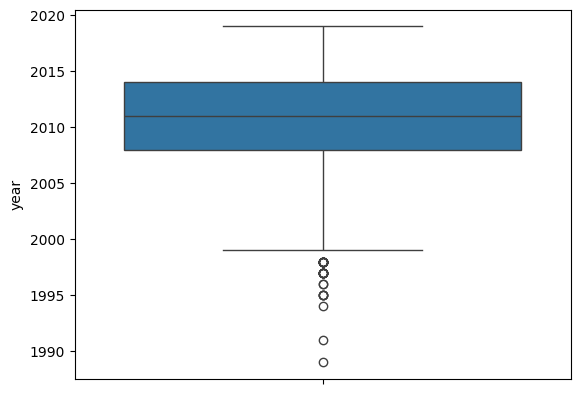

In [25]:
sns.boxplot(df["year"])

We will remove the outlier data points based on registeration year using IQR

In [26]:
# Removing outlier using IQR
def remove_outlier(df, col):

  # 1. Compute Quantiles
  q1 = np.quantile(df[col], .25)
  q3 = np.quantile(df[col], .75)

  IQR = q3 - q1

  # 2. Compute the upper & lower limit
  upper_limit = q3 + 1.5 * IQR
  lower_limit = q1 - 1.5 * IQR

  return df[(df[col] < upper_limit) & (df[col] > lower_limit)]

df = remove_outlier(df, 'year')

Text(0, 0.5, 'Count of Inspections')

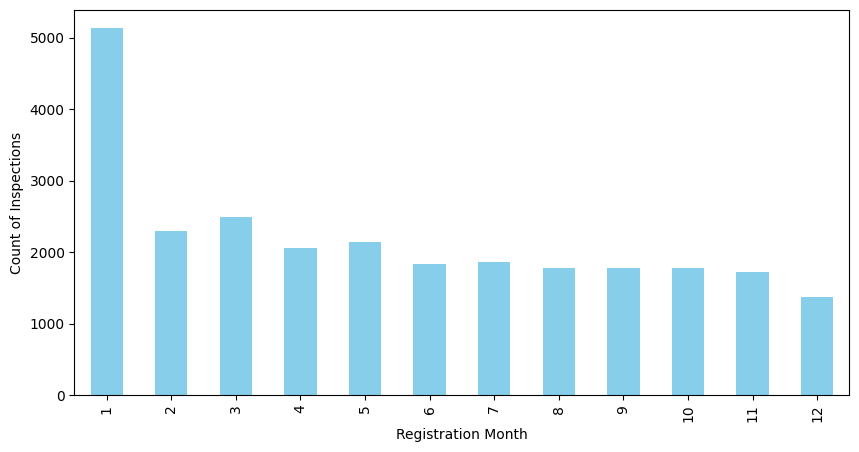

In [27]:
plt.figure(figsize=(10, 5))

# Option 1: Define the color variable
color = 'skyblue' 

# Option 2: Pass the string directly: .plot.bar(color='skyblue')
df.groupby(['month'])['appointmentId'].count().plot.bar(color=color)

plt.xlabel("Registration Month")
plt.ylabel("Count of Inspections")

There's significant number of cars registered in January

<Axes: ylabel='odometer_reading'>

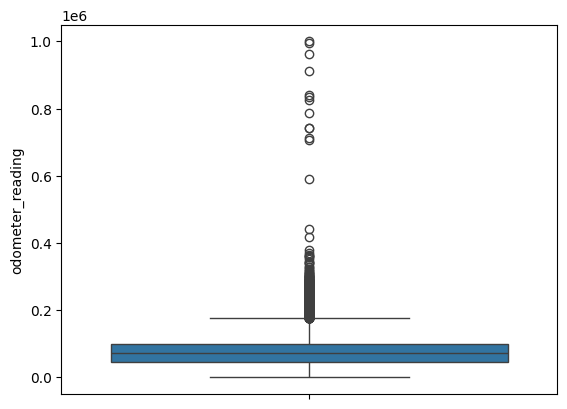

In [28]:
sns.boxplot(df["odometer_reading"])

Odometer reading has a lot of outliers, we will remove using IQR

In [29]:
# Removing outliers using IQR
df = remove_outlier(df, 'odometer_reading')

### Bivariate Analysis

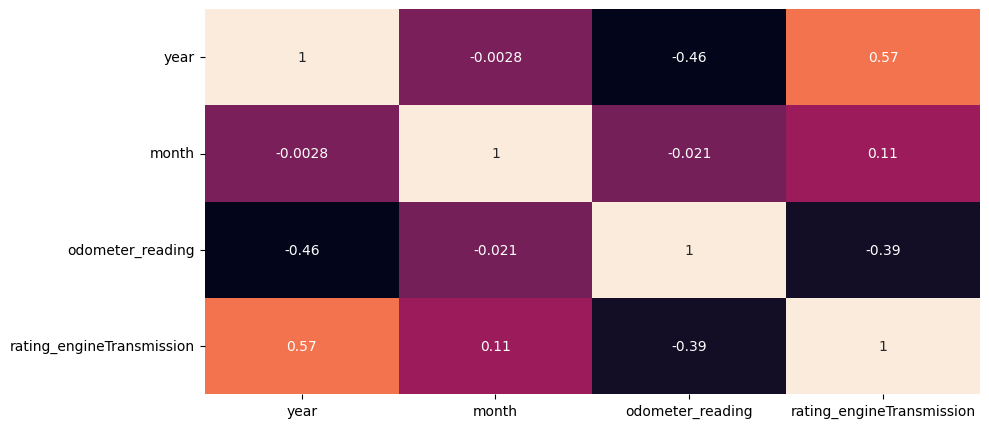

In [30]:
# Visualising pearson's correlation
cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[cols].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True, cbar=False)
plt.show()

In [31]:
df.groupby(['month'])['rating_engineTransmission'].mean()

month
1     3.378056
2     3.721064
3     3.674327
4     3.701046
5     3.722488
6     3.716004
7     3.715158
8     3.723547
9     3.740816
10    3.732484
11    3.733195
12    3.706259
Name: rating_engineTransmission, dtype: float64

Hypothesis: no relation between the year and rating_engineTransmission

Analyzing 'inspection_hour' vs 'rating_engineTransmission'
inspection_hour
9     3.620536
10    3.694343
11    3.684056
12    3.652490
13    3.677990
14    3.642771
15    3.649489
16    3.652599
17    3.613524
18    3.496656
19    3.536364
20    3.470588
21    4.000000
Name: rating_engineTransmission, dtype: float64


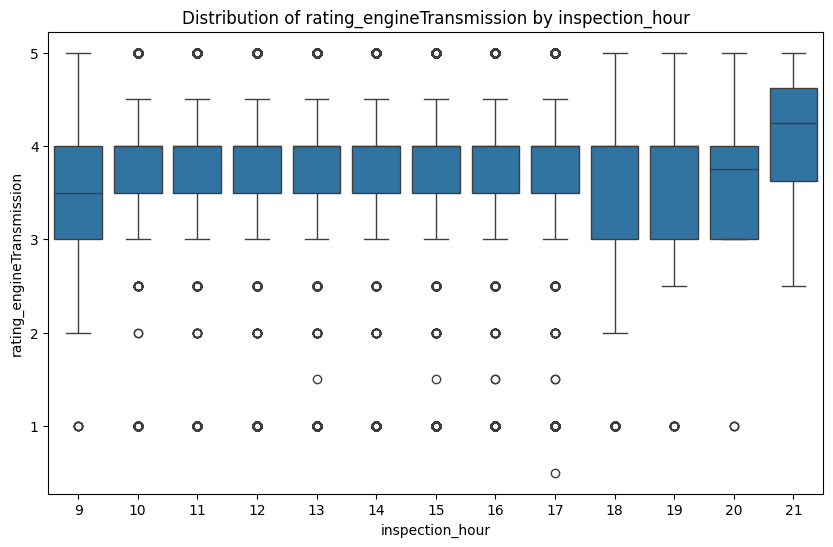

Kruskal-Wallis results: Statistic=40.2582, p-value=0.0001
Significant differences found in rating_engineTransmission across inspection_hour.
Analyzing 'inspection_mon' vs 'rating_engineTransmission'
inspection_mon
1    3.583214
2    3.672426
3    3.666472
4    3.693875
Name: rating_engineTransmission, dtype: float64


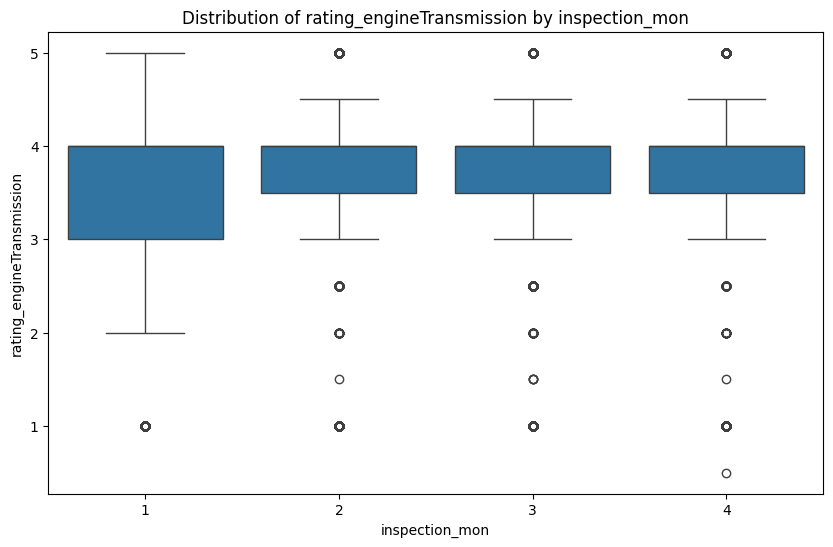

Kruskal-Wallis results: Statistic=77.4199, p-value=0.0000
Significant differences found in rating_engineTransmission across inspection_mon.
Analyzing 'inspection_dow' vs 'rating_engineTransmission'
inspection_dow
Friday       3.635660
Monday       3.649896
Saturday     3.661596
Sunday       3.642591
Thursday     3.650086
Tuesday      3.664880
Wednesday    3.644702
Name: rating_engineTransmission, dtype: float64


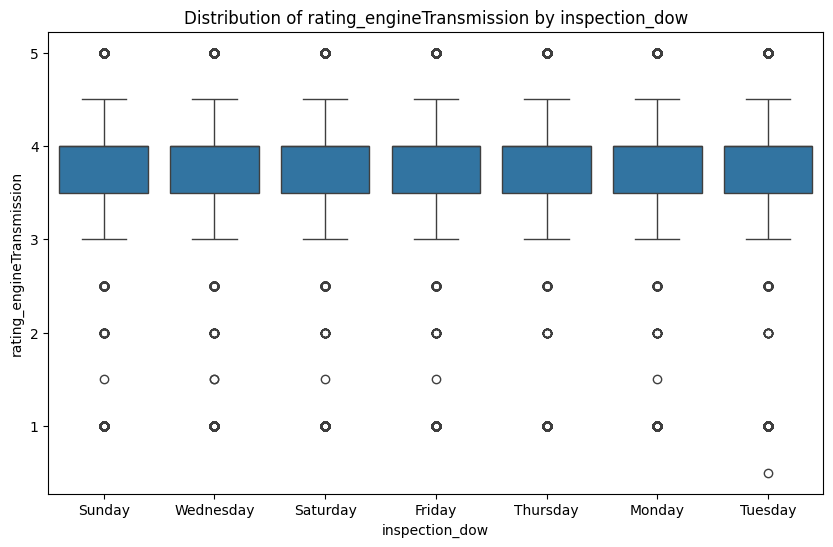

Kruskal-Wallis results: Statistic=8.5651, p-value=0.1996
No significant differences found in rating_engineTransmission across inspection_dow.
Analyzing 'month' vs 'rating_engineTransmission'
month
1     3.378056
2     3.721064
3     3.674327
4     3.701046
5     3.722488
6     3.716004
7     3.715158
8     3.723547
9     3.740816
10    3.732484
11    3.733195
12    3.706259
Name: rating_engineTransmission, dtype: float64


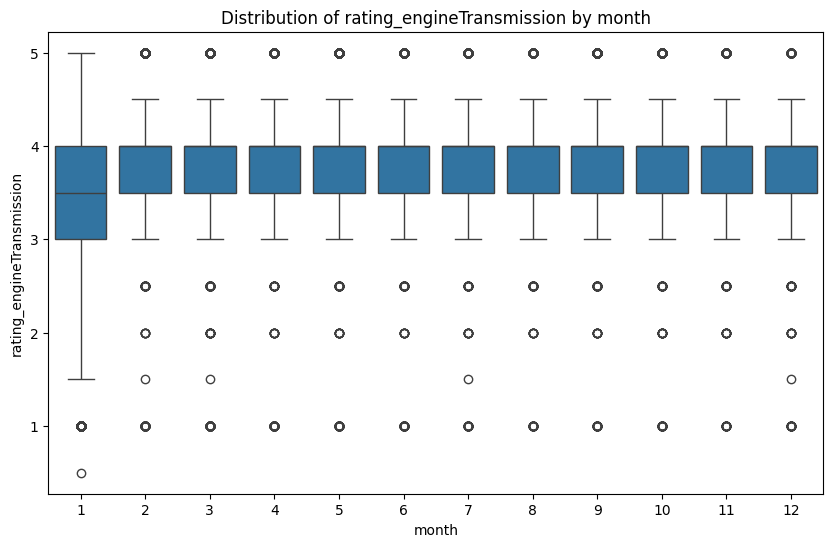

Kruskal-Wallis results: Statistic=211.0329, p-value=0.0000
Significant differences found in rating_engineTransmission across month.
Analyzing 'year' vs 'rating_engineTransmission'
year
2000    1.083333
2001    1.000000
2002    1.077320
2003    1.075269
2004    2.304493
2005    3.355191
2006    3.335061
2007    3.378812
2008    3.343949
2009    3.450828
2010    3.650890
2011    3.691712
2012    3.718903
2013    3.793586
2014    3.916752
2015    4.075938
2016    4.235736
2017    4.444907
2018    4.726898
2019    5.000000
Name: rating_engineTransmission, dtype: float64


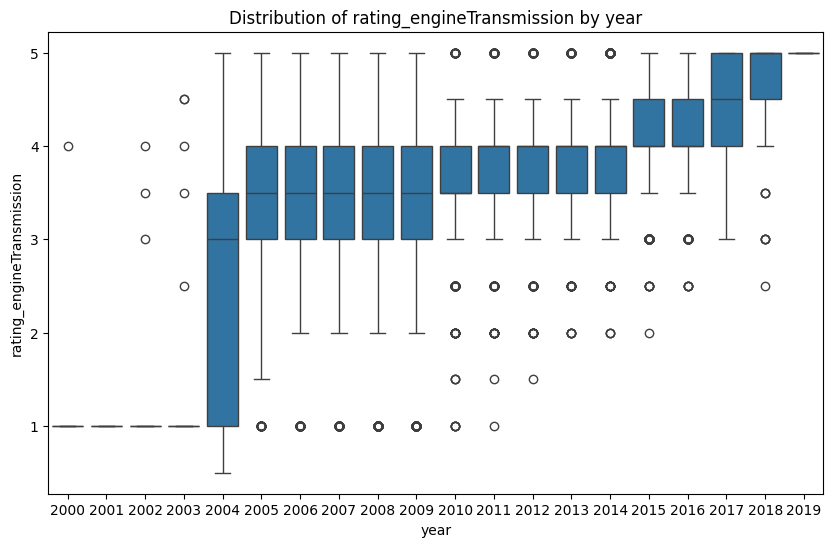

Kruskal-Wallis results: Statistic=7707.4147, p-value=0.0000
Significant differences found in rating_engineTransmission across year.


In [32]:
def analyze_temporal_trends(feature, target='rating_engineTransmission'):
    # Check distribution of the feature
    print(f"Analyzing '{feature}' vs '{target}'")
    grouped = df.groupby(feature)[target].mean()
    print(grouped)

    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y=target, data=df)
    plt.title(f"Distribution of {target} by {feature}")
    plt.show()

    # Perform statistical test
    unique_values = df[feature].unique()
    if len(unique_values) > 2:
        # Use Kruskal-Wallis test for >2 groups
        groups = [df[df[feature] == val][target] for val in unique_values]
        stat, p = kruskal(*groups)
        test_name = "Kruskal-Wallis"
    else:
        # Use t-test for 2 groups
        group1 = df[df[feature] == unique_values[0]][target]
        group2 = df[df[feature] == unique_values[1]][target]
        stat, p = ttest_ind(group1, group2)
        test_name = "t-test"

    print(f"{test_name} results: Statistic={stat:.4f}, p-value={p:.4f}")
    if p < 0.05:
        print(f"Significant differences found in {target} across {feature}.")
    else:
        print(f"No significant differences found in {target} across {feature}.")

# Analyze temporal trends for each feature
temporal_features = ['inspection_hour', 'inspection_mon', 'inspection_dow','month','year']
for feature in temporal_features:
    analyze_temporal_trends(feature)

In [33]:
# Calculate Spearman correlation for 'year' and 'rating_engineTransmission'
year_corr, year_p = spearmanr(df['year'], df['rating_engineTransmission'])
print(f"Spearman Correlation (Year vs Rating): {year_corr:.4f}, p-value: {year_p:.4f}")

Spearman Correlation (Year vs Rating): 0.5112, p-value: 0.0000


* Features like Registration month, year, inspection hour, month are likely important predictors for the model. they are capturing variability in rating_engineTransmission
* Above is supported by positive correlation (0.5112) between registration year & ratings- as the registration year increases (newer registrations), engine ratings tend to improve.
* Features like inspection day of week have no Significant Differences: These features may have little impact on the target. We can exclude them from the model to reduce noise

## Feature Engineering

In [34]:
cat_cols = [label for label in df.columns if any(x in label for x in ['engineTransmission_'])]

In [35]:
df_cat = df[cat_cols]
df_cat = df_cat.reset_index().drop('index', axis=1)
df_cat_encoded = pd.get_dummies(df_cat, dtype=bool, drop_first=True)

In [36]:
# Check for any constant columns
df_cat_encoded.loc[:, (df_cat_encoded == df_cat_encoded.iloc[0]).all()].columns

Index([], dtype='object')

In [37]:
# List all unique suffixes based on column names
suffixes = df_cat_encoded.columns.str.extract(r'.*_(.*)$')[0].unique()

for suffix in suffixes:
    matching_columns = [col for col in df_cat_encoded.columns if f'_{suffix}' in col]
    # remove the numeric part (_0, _1, _2, etc.) and the suffix (_Jump Start) to create the base column name
    base_name = re.sub(r'_\d+_' + re.escape(suffix) + '$', '', matching_columns[0])
    # Combine the selected columns (using OR operation)
    df_cat_encoded[f'{base_name}_{suffix}'] = df_cat_encoded[matching_columns].any(axis=1).astype(int)
    
    # Drop the original individual columns after combining
    df_cat_encoded.drop(columns=matching_columns, inplace=True)

print(df_cat_encoded.shape)

(25514, 52)


In [38]:

# Add constant term
X = add_constant(df_cat_encoded)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                                              feature          VIF
0            engineTransmission_battery_value_Yes_Yes     1.036859
1   engineTransmission_battery_cc_value_Dischargin...     1.037856
2      engineTransmission_battery_cc_value_Jump Start     1.220059
3     engineTransmission_battery_cc_value_Not Working     1.161286
4            engineTransmission_battery_cc_value_Weak     1.198524
5             engineTransmission_battery_cc_value_yes  1013.921603
6   engineTransmission_engineOil_cc_value_Leakage ...     1.107068
7   engineTransmission_engineOil_cc_value_Leakage ...     1.183081
8   engineTransmission_engineOil_cc_value_Leakage ...     1.513738
9   engineTransmission_engineOil_cc_value_Leakage ...     1.119304
10      engineTransmission_engineOil_cc_value_Leaking     1.510259
11    engineTransmission_engineOil_cc_value_Level Low     1.197640
12  engineTransmission_engineOil_cc_value_Low Pres...     1.027967
13  engineTransmission_engineOil_cc_value_Mixed wi...     1.15

In [39]:
# combine encoded columns with df
df= df.reset_index()
df_features = pd.merge(df, df_cat_encoded, left_index=True, right_index=True)
df_features = df_features.drop(cat_cols, axis=1)

combined_columns= [label for label in df_features.columns if any(x in label for x in ['engineTransmission_'])]

df_features[combined_columns] = df_features[combined_columns].astype('O')
df_features['rating_engineTransmission'] = df_features['rating_engineTransmission'].astype(float)

In [40]:
target = 'rating_engineTransmission'
# Ensure all combined columns are cleaned
for column in combined_columns:
    df_features[column] = df_features[column].fillna('Unknown').astype(str)
for column in combined_columns:
    # Group the target variable by the categories in the column
    groups = [df_features[target][df_features[column] == category] for category in df_features[column].unique()]
     # Filter out categories with fewer than 2 data points
    grouped_data = [group for group in groups if len(group) > 1]
    
    if len(grouped_data) < 2:  # If fewer than two valid groups, skip the ANOVA
        print(f"Skipping ANOVA test for {column}: not enough data in one or more groups.")
        continue
    try:
        # Perform ANOVA test
        f_statistic, p_value = stats.f_oneway(*groups)
        
        # Print results
        print(f"ANOVA Test for Column: {column}")
        print(f"F-Statistic: {f_statistic:.4f}, P-Value: {p_value:.4f}")
        
        # Check significance
        if p_value < 0.05:
            print("Result: Significant relationship with the target variable.\n")
        else:
            print("Result: No significant relationship with the target variable.\n")
    except ValueError as e:
        print(f"Error for column {column}: {e}")

ANOVA Test for Column: engineTransmission_battery_value_Yes_Yes
F-Statistic: 148.2844, P-Value: 0.0000
Result: Significant relationship with the target variable.

ANOVA Test for Column: engineTransmission_battery_cc_value_Discharging light glowing
F-Statistic: 31.7609, P-Value: 0.0000
Result: Significant relationship with the target variable.

ANOVA Test for Column: engineTransmission_battery_cc_value_Jump Start
F-Statistic: 292.2760, P-Value: 0.0000
Result: Significant relationship with the target variable.

ANOVA Test for Column: engineTransmission_battery_cc_value_Not Working
F-Statistic: 192.2519, P-Value: 0.0000
Result: Significant relationship with the target variable.

ANOVA Test for Column: engineTransmission_battery_cc_value_Weak
F-Statistic: 433.5518, P-Value: 0.0000
Result: Significant relationship with the target variable.

Skipping ANOVA test for engineTransmission_battery_cc_value_yes: not enough data in one or more groups.
ANOVA Test for Column: engineTransmission_engine

In [41]:

df_clean = df_features.drop(['appointmentId','inspectionStartTime',
                          'inspection_dow','inspection_date', 'index',
                          'engineTransmission_battery_cc_value_yes', # constant variable
                          'engineTransmission_exhaustSmoke_cc_value_Leakage from manifold'], axis = 1)

## Modeling

In [42]:
# Split into training set & target
train = df_clean.drop('rating_engineTransmission', axis=1).reset_index().drop('index', axis=1)
target = df_clean['rating_engineTransmission'].reset_index().drop('index', axis=1)

X = train
y = target

Classes like 0.5 and 1.5 have very few observations, which is causing challenges in classification models.

In [43]:

# Identify categorical columns (if necessary)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)  # One-hot encode categorical features

# Split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Generating KFold Split for cross validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [44]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Print the R squared scores
rf_train_score = rf.score(X_train, y_train)
rf_val_score = rf.score(X_val, y_val)
print(rf_train_score, rf_val_score)

0.9557277241729552 0.6500562926353097


In [45]:
# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Print the R squared scores
dt_train_score = dt.score(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print(dt_train_score, dt_val_score)

1.0 0.36793741184587303


In [46]:
# XGboost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Print the R squared scores
xgb_train_score = xgb.score(X_train, y_train)
xgb_val_score = xgb.score(X_val, y_val)
print(xgb_train_score, xgb_val_score)

0.8129058480262756 0.6559081077575684


In [47]:
# LGBM Regressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

# Print the R squared scores
lgbm_train_score = lgbm.score(X_train, y_train)
lgbm_val_score = lgbm.score(X_val, y_val)
print(lgbm_train_score, lgbm_val_score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 16328, number of used features: 56
[LightGBM] [Info] Start training from score 3.651825
0.7485211687263671 0.6722523656978543


XGboost & LightGBM are models which are showing generalization over the data

Decision tree & Random Forest is overfitting

In [48]:
# Tuning the XGBoost model
# Using RandomizedSearchCV for hyperparameter tuning
parameters = {'max_depth': [3, 5, 6, 10, 15, 20],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.4, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
              'n_estimators': [100, 500, 1000],
             'reg_alpha': [0, 0.01, 0.05],
    'reg_lambda': [0, 0.01, 0.05]}

xgb = XGBRegressor()
rscv_xgb = RandomizedSearchCV(xgb, parameters, n_iter=20,scoring='r2', verbose=30, n_jobs=-1, cv=3, random_state=42)
rscv_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bylevel': array([0.4, 0....7, 0.8, 0.9]), 'colsample_bytree': array([0.4, 0....7, 0.8, 0.9]), 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,30
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [49]:
# Store the best estimator
xgb_best_est = rscv_xgb.best_estimator_
# Compute the R Squared score for the best estimator
train_score = xgb_best_est.score(X_train, y_train)
validation_score = xgb_best_est.score(X_val, y_val)

print(train_score, validation_score)

0.9997455477714539 0.6470159292221069


In [50]:
# Using RandomizedSearchCV for hyperparameter tuning
parameters = { 'num_leaves': [20, 30, 50],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'objective': ['regression'],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
              }
lgbm = LGBMRegressor(verbose=-1)
rscv_lgbm = RandomizedSearchCV(lgbm, parameters, n_iter=50,scoring='r2', verbose=3, n_jobs=-1, cv=3, random_state=42)
rscv_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,LGBMRegressor(verbose=-1)
,param_distributions,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [5, 10, ...], 'n_estimators': [100, 200, ...], 'num_leaves': [20, 30, ...], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [51]:
# Store the best estimator
lgbm_best_est = rscv_lgbm.best_estimator_
# Compute the R Squared score for the best estimator
train_score = rscv_lgbm.score(X_train, y_train)
validation_score = rscv_lgbm.score(X_val, y_val)

print(train_score, validation_score)

0.7469341299994474 0.6726672425273397


In [52]:
from lightgbm import LGBMRegressor

# Initialize the Regressor instead of Classifier
lgbm_best_est = LGBMRegressor()

X_train_final = pd.concat((X_train, X_val), axis=0)
y_train_final = pd.concat((y_train, y_val), axis=0)

# Force target to be integer type for Classification
lgbm_best_est.fit(X_train_final, y_train_final.astype(int))

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [53]:
# Compute R2 Score on test set
final_train_score = lgbm_best_est.score(X_train, y_train)
final_test_score = lgbm_best_est.score(X_test, y_test)

print("Final Train Score: {}".format(final_train_score))
print("Final Test Score: {}".format(final_test_score))

Final Train Score: 0.6981596495422949
Final Test Score: 0.6453023001760172


In [54]:
# Storing the model in a pickle file
final_model = lgbm_best_est
with open('final_model_lgbm.pickle', 'wb') as files:
    pickle.dump(final_model, files)

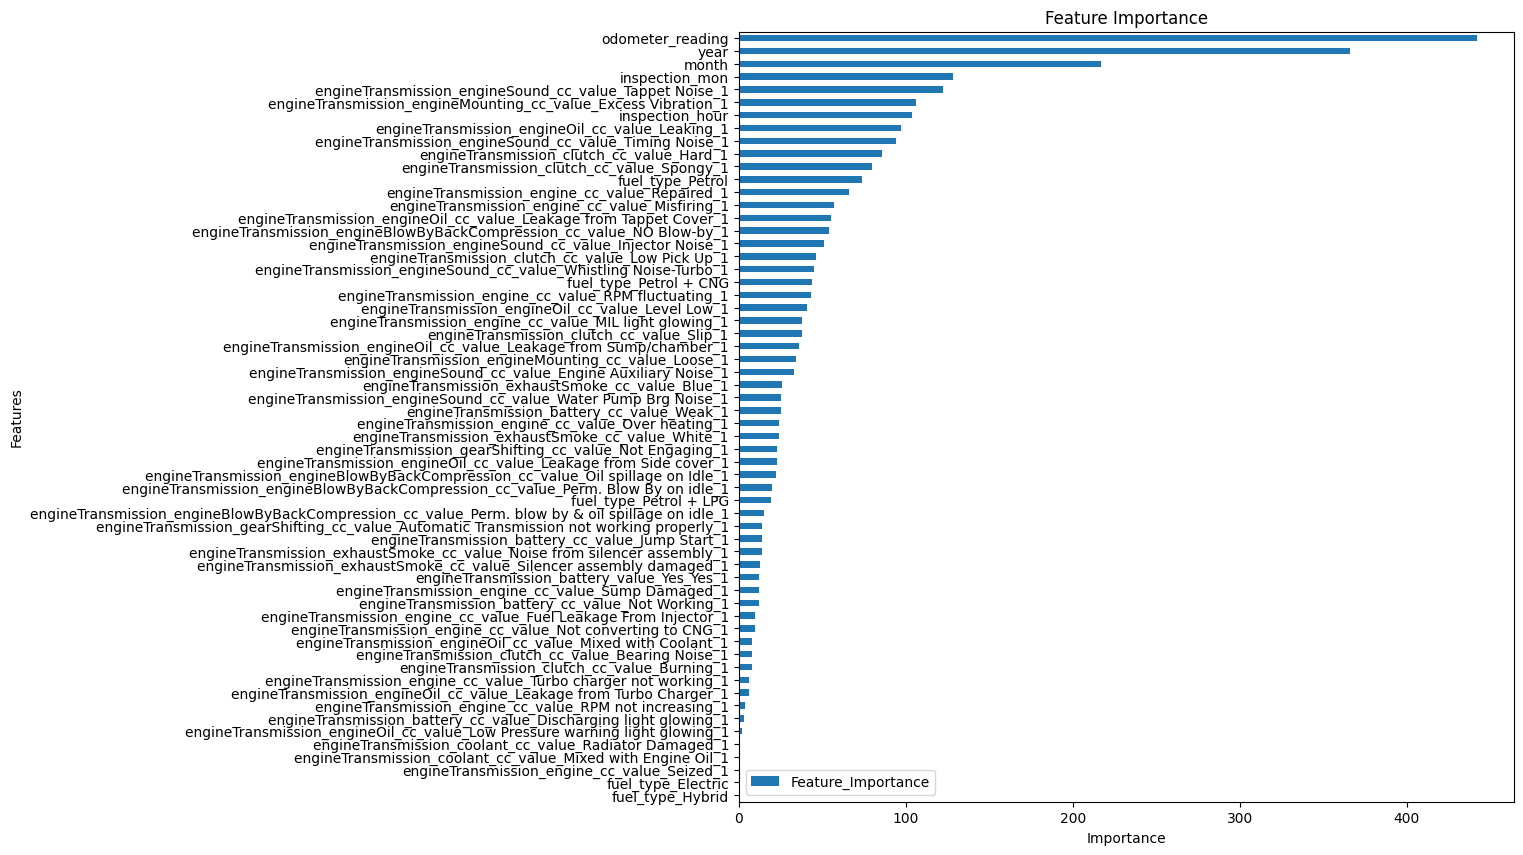

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# 1. Initialize the Regressor (fixes the 'continuous' label error)
lgbm_best_est = LGBMRegressor()

# 2. Prepare the data (Ensure X_train, X_val, y_train, y_val are loaded from earlier cells)
X_train_final = pd.concat((X_train, X_val), axis=0)
y_train_final = pd.concat((y_train, y_val), axis=0)

# 3. Fit the model
lgbm_best_est.fit(X_train_final, y_train_final)

# 4. Plot Feature Importances
feature_importances = lgbm_best_est.feature_importances_
features = X_train_final.columns

feat_imp_df = pd.DataFrame({'Features': features, 'Feature_Importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='Feature_Importance')

feat_imp_df.plot(kind='barh', x='Features', y='Feature_Importance', figsize=(10, 10))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

In [56]:
feat_imp_df.sort_values(by='Feature_Importance', ascending=False).head(10)


,Features,Feature_Importance
2,odometer_reading,442
0,year,366
1,month,217
4,inspection_mon,128
40,engineTransmission_engineSound_cc_value_Tappet...,122
36,engineTransmission_engineMounting_cc_value_Exc...,106
3,inspection_hour,104
19,engineTransmission_engineOil_cc_value_Leaking_1,97
41,engineTransmission_engineSound_cc_value_Timing...,94
54,engineTransmission_clutch_cc_value_Hard_1,86
